<a href="https://colab.research.google.com/github/RomainGratier/image-recognition-groceries/blob/main/Image_classification_groceries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Objective

In this project, image classification is performed using three different types of deep convolutional neural networks in order to learn and experiment with deep neural networks.

For the purpose of this project, the dataset was re-classified into 3 classes of fruits, vegetables, and packages. View readme for more info.

In [ ]:
# data set reference
@inproceedings{klasson2019hierarchical,
  title={A Hierarchical Grocery Store Image Dataset with Visual and Semantic Labels},
  author={Klasson, Marcus and Zhang, Cheng and Kjellstr{\"o}m, Hedvig},
  booktitle={IEEE Winter Conference on Applications of Computer Vision (WACV)},
  year={2019}
}

SyntaxError: ignored

# Some code snippets which might be useful to get you started

In [ ]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
#from keras_applications.resnet import ResNet50
from keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

We now create some data generators for working with the flowers data

Adapt the code below to work with the generators, then proceed with the experiments!

# Run This: Confusion matrix function

In [ ]:
#@title Run this confusion matrix function
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15),dpi=200)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

  


# 2. Initial Set-up

## 2.1 Mount Google Drive and set the train, validation, and test data set path

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## set train, validation, and test paths 
train_path = '/content/gdrive/MyDrive/groceries-image-recognition/dataset/train' 
validation_path = '/content/gdrive/MyDrive/groceries-image-recognition/dataset/val'
test_path = '/content/gdrive/MyDrive/groceries-image-recognition/dataset/test'

## 2.2 Intial preprocessing of data
This is the initial preprocessing of data without any data augmentation before the creation of the network. This is just the start.

In [ ]:
Classes = ['Zucchini', #Soy-Milk, Sour-Milk, plume, papaya, Nectarine, garlic
           'Yoghurt',
           'Tomato',
           'Soyghurt',
           'Sour-Cream',
           'Satsumas',
           'Red-Grapfruit',
           'Red-Beet',
           'Potato',
           'Pomegranate',
           'Pineapple',
           'Pepper',
           'Pear',
           'Peach',
           'Passion-Fruit',
           'Orange',
           'Onion',
           'Oatghurt',
           'Oat-Milk',
           'Milk',
           'Melon',
           'Mango',
           'Lime',
           'Lemon',
           'Leek',
           'Kiwi',
           'Juice',
           'Ginger',
           'Cucumber',
           'Carrots',
           'Cabbage',
           'Brown-Cap-Mushroom',
           'Banana',
           'Avocado',
           'Aubergine',
           'Asparagus',
           'Apple'
           ]

train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = Classes, batch_size = 50)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = Classes, batch_size = 10)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = Classes, batch_size = 10)

Found 2296 images belonging to 37 classes.
Found 286 images belonging to 37 classes.
Found 2124 images belonging to 37 classes.


In [ ]:
#take a look at output of the generators

for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    

data batch shape: (50, 224, 224, 3)
labels batch shape: (50, 37)


## 2.3 Sample images

Some vegetables and fruits have similar shapes while the inter-class variance to packages is high

In [ ]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import keras
from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
#from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

## 4.2 ResNet50

In [ ]:
from keras.applications.resnet50 import ResNet50

resnet50_base_model = ResNet50(weights='imagenet', include_top=False)
#resnet50_trainable_model = ResNet50(weights=None, include_top=False)



94773248/94765736 [==============================] - 3s 0us/step


In [ ]:
resnet50_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
## building base model with frozen weights

base_x = resnet50_base_model.output
global_pooling_x = GlobalAveragePooling2D()(base_x)
#add dense layer
dense_layer = Dense(512, activation='relu')(global_pooling_x)
#add final output layer
base_prediction = Dense(37, activation = 'softmax')(dense_layer)

#create the whole network
resnet_transfer_model_1 = Model(inputs=resnet50_base_model.input, outputs=base_prediction)

resnet_transfer_model_1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

### Data augmentation and setting generator

In [ ]:
## Added more types of Data Augmentation for experimenting
## Goal is to get more data

res_train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

res_test_datagen = ImageDataGenerator(rescale=1./255)

res_train_generator = res_train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

res_validation_generator = res_test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames_res = res_train_generator.filenames
steps_train_res = len(train_filenames_res)/res_train_generator.batch_size

## set steps per epoch for validation
validation_filenames_res = res_validation_generator.filenames
steps_valid_res = len(validation_filenames_res)/res_validation_generator.batch_size


print(len(validation_filenames_res), " ", steps_valid_res)

Found 2446 images belonging to 37 classes.
Found 296 images belonging to 37 classes.
296   29.6


### Compile and fit model

In [ ]:
resnet_transfer_model_1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

resnet_model_1_fit_generator = resnet_transfer_model_1.fit_generator(
        res_train_generator,
        steps_per_epoch=steps_train_res,
        epochs=30,
        validation_data=res_validation_generator,
        validation_steps=steps_valid_res)


Epoch 1/30
123/122 [==============================] - 1015s 8s/step - loss: 0.9936 - acc: 0.7400 - val_loss: 11.4207 - val_acc: 0.0169
Epoch 2/30
123/122 [==============================] - 67s 549ms/step - loss: 0.2184 - acc: 0.9342 - val_loss: 17.6276 - val_acc: 0.0338
Epoch 3/30
123/122 [==============================] - 67s 547ms/step - loss: 0.1419 - acc: 0.9554 - val_loss: 32.0012 - val_acc: 0.0709
Epoch 4/30
123/122 [==============================] - 67s 547ms/step - loss: 0.1160 - acc: 0.9661 - val_loss: 9.3843 - val_acc: 0.0169
Epoch 5/30
123/122 [==============================] - 67s 546ms/step - loss: 0.0936 - acc: 0.9726 - val_loss: 6.3758 - val_acc: 0.0642
Epoch 6/30
123/122 [==============================] - 67s 546ms/step - loss: 0.0824 - acc: 0.9787 - val_loss: 6.9361 - val_acc: 0.1723
Epoch 7/30
123/122 [==============================] - 67s 547ms/step - loss: 0.0851 - acc: 0.9771 - val_loss: 11.2659 - val_acc: 0.4020
Epoch 8/30
123/122 [==============================] 

In [ ]:
resnet_transfer_model_1.save('/content/gdrive/MyDrive/groceries-image-recognition/resnet50_frozen_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/groceries-image-recognition/resnet50_frozen_model/assets


### Plot Accuracy and Loss

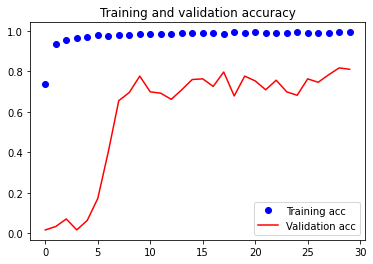

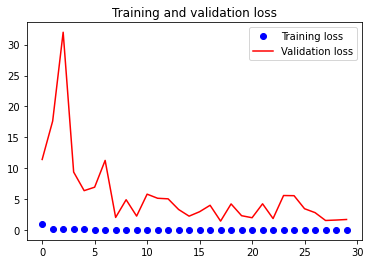

In [ ]:

import matplotlib.pyplot as plt

acc = resnet_model_1_fit_generator.history['acc']
val_acc = resnet_model_1_fit_generator.history['val_acc']
loss = resnet_model_1_fit_generator.history['loss']
val_loss = resnet_model_1_fit_generator.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predict

In [ ]:
resnet_test_datagen = ImageDataGenerator(rescale=1./255)

resnet_test_generator = resnet_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = resnet_test_generator.filenames
nb_samples = len(filenames)
#nb_samples


predict = resnet_transfer_model_1.predict_generator(resnet_test_generator,steps = nb_samples, verbose=2)


Found 2305 images belonging to 37 classes.
2305/2305 - 45s


### Confusion matrix

Confusion matrix, without normalization
[[247   0   0 ...   2   0   0]
 [  0  14   0 ...   0   0   0]
 [  0   0  21 ...   0   0   0]
 ...
 [  0   2   0 ...  85   0   0]
 [  0   0   0 ...   0 162   0]
 [  0   1   0 ...   0   0  27]]


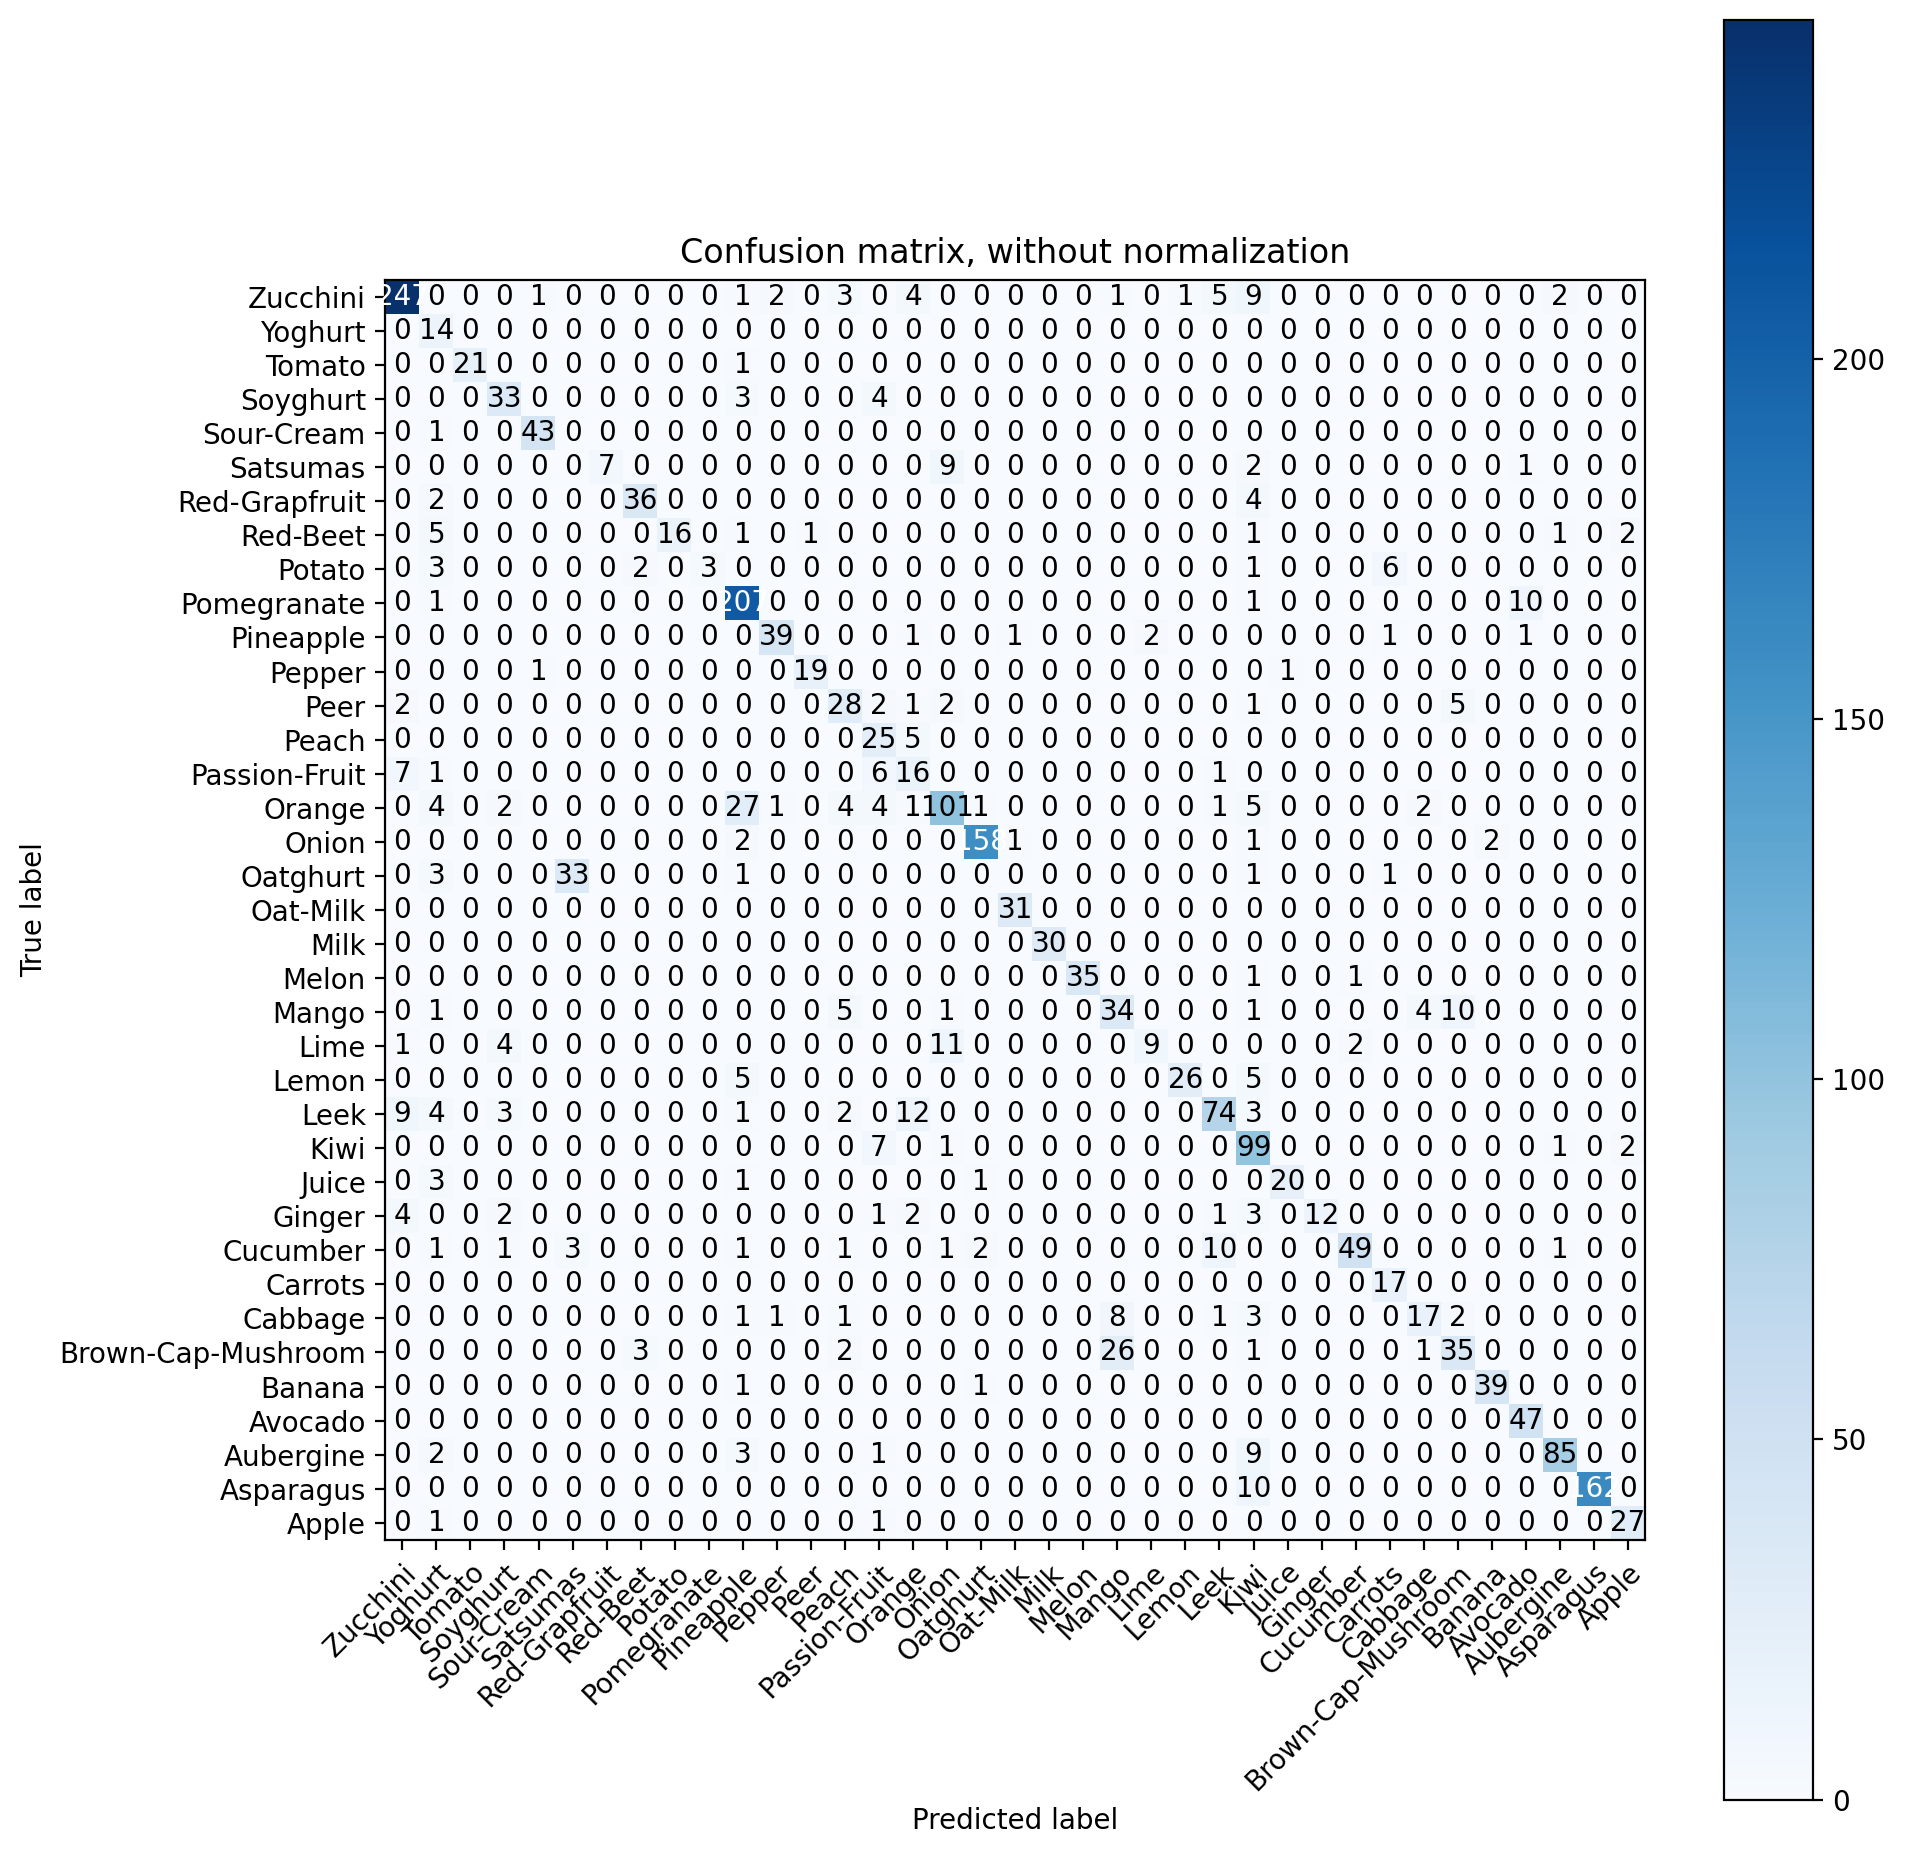

In [ ]:
r_y_true = resnet_test_generator.classes
r_y_pred = predict.argmax(axis=1)
plot_confusion_matrix(r_y_true, r_y_pred, classes=Classes,
                      title='Confusion matrix, without normalization')

#### Analysis

After viewing the results of the accuracy and loss, and confusion matrix. This has proved to be the best model with 98-99% accuracy for validation and only 1 image classified incorrectly when predicted.

When the accuracy and loss graphs for training and validation are observed, it can been that the model is learning, starting from 92% accuracy (already very high but not surprising considering that it is being run on trained weights from imagenet) in the first epoch all the way up to 99%+. The validation results varied during the first 10 epochs but towards the end, the results were consistently around 98-99%. The performance is identical in the loss graph where the model shows consistent training and validation towards the last epoch. 

Since only one image was classified incorrectly, 99.62% of the images were corect, it can be concluded that this model is by far the best model.

# 5. Conclusion

When comparing the following accuracy of all the models:

1.   Baseline Convolution Model with dropout layer
 - validation accuracy around 86%, 35/262 images classified incorrectly
2.   VGG16 transfer model with dropout layer
 - validation accuracy range of 86-89%, 26/262 images classified incorrectly
3.   VGG16 transfer model without dropout layer
 - validation accuracy range of 89-90%, 18/262 images classified incorrectly
4.   VGG16 transfer model with learning rate changed from 1e-4 to 1e-5
 - validation accuracy range of 92-94%, 17/262 images classified incorrectly
5.   ResNet50 transfer model
 - validation accuracy around 99%, only 1/262 images classified incorrectly

The ResNet50 proved to be the best model in terms of both accuracy and loss. The accuracy validation results ranged around 98-99% while the confusion matrix described only one image (fruits) classified incorrectly. In conclusion, the problem of classifying different groceries at a high level can be solved using multiple convolutional neural networks such as the ResNet50. With a good, sufficient(large) dataset, this network can definitely be used in real life situations, the same cannot be said for the VGG models because the accuracy rates and predictons were not good enough.
